In [1]:
import gpflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow_probability as tfp

from gpflow.utilities import print_summary
from gpflow.config import default_float
from gpflow.ci_utils import ci_niter, is_continuous_integration

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

# Generalized Gaussian Process Models

The Generalized gaussian Process Model is comparable a reference to the Genezalized Linear Model.
REFERENZE

Chan, A. and Dong, D. Generalized Gaussian Process Models 

$\theta \sim p(\theta)\\ f \sim \mathcal {GP}(m(x;\,\theta), \, k(x,\,x';\,\theta))\\ y_{i} \sim p(y \vert g(f(x_{i} ))$

## Exponential

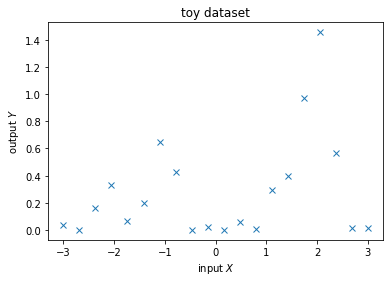

In [16]:
X = np.linspace(-3, 3, 20)
Y = np.random.exponential(np.sin(X)**2)

plt.figure()
plt.plot(X,Y,'x')
plt.xlabel('input $X$')
plt.ylabel('output $Y$')
plt.title('toy dataset')
plt.show()

data = (X[:,None], Y[:,None])

In [17]:
kernel = gpflow.kernels.SquaredExponential() + gpflow.kernels.Bias()
#kernel = gpflow.kernels.Matern32() + gpflow.kernels.Bias()
likelihood = gpflow.likelihoods.Exponential()
model = gpflow.models.GPMC(data, kernel, likelihood)

In [18]:
gpflow.utilities.print_summary(model)

name,class,transform,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.V,Parameter,,True,"(20, 1)",float64,[[0....


In [6]:
#k1 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=4.0)*gpflow.kernels.Periodic(period=12.0)
#k2 = gpflow.kernels.White()
#k3 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=90.0)
#kernel = k2+k3# + k2 + k
#likelihood = gpflow.likelihoods.Exponential()

#model = gpflow.models.GPMC((X_train, y_train), kernel=kernel, likelihood=likelihood)


In [7]:
model.kernel.kernels[0].lengthscale.prior = tfp.distributions.Normal(f64(1.), f64(1.))
model.kernel.kernels[0].variance.prior =  tfp.distributions.Gamma(f64(1.), f64(1.))
#model.kernel.kernels[0].period.prior = tfp.distributions.Normal(f64(np.pi), f64(1.))
model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))


In [8]:
gpflow.utilities.print_summary(model)

name,class,transform,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.V,Parameter,,True,"(20, 1)",float64,[[0....


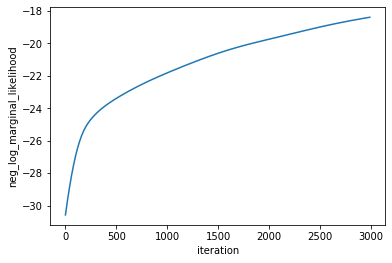

In [9]:
@tf.function(autograph=False)
def optimization_step(optimizer, model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.log_marginal_likelihood()
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return - objective

def run_adam(model, iterations):
    logf = []
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = optimization_step(adam, model)
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

maxiter = ci_niter(3000)
logf = run_adam(model, maxiter) # start near Maximum a posteriori (MAP)

plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('neg_log_marginal_likelihood');


In [10]:
num_samples = 5000

hmc_helper =  gpflow.optimizers.SamplingHelper(
    model.trainable_parameters,
    model.log_marginal_likelihood
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=10,
    step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc,
    num_adaptation_steps=10,
    target_accept_prob=f64(.75),
    adaptation_rate=0.1
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=300,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, _ = run_chain_fn()



In [11]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []

for i in range(num_samples):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)


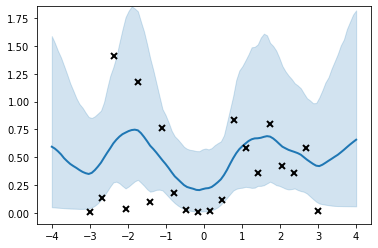

In [12]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)));


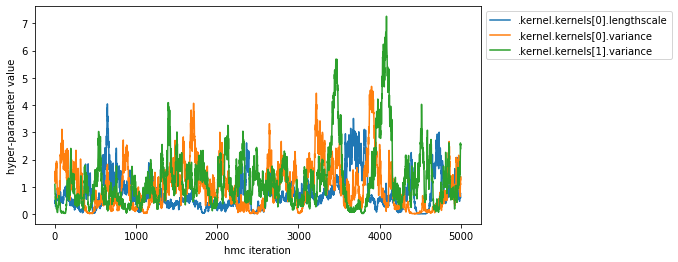

In [13]:
parameter_samples = hmc_helper.convert_constrained_values(samples)
param_to_name = {param: name for name, param in
                 gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in
                 enumerate(model.trainable_parameters)}
hyperparameters = ['.kernel.kernels[0].lengthscale',
                   '.kernel.kernels[0].variance',
                   '.kernel.kernels[1].variance']


plt.figure(figsize=(8,4))
for hp in hyperparameters:
    plt.plot(parameter_samples[name_to_index[hp]], label=hp)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value');

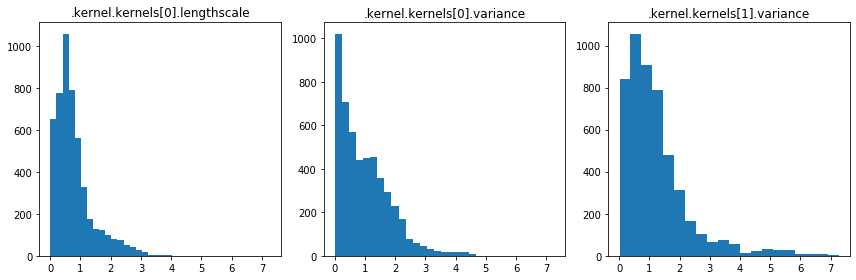

In [14]:
fig, axarr = plt.subplots(1, len(hyperparameters), sharex=True, figsize=(12,4))
for i, hyp in enumerate(hyperparameters):
    ax = axarr[i]
    ax.hist(parameter_samples[name_to_index[hyp]],bins=20)
    ax.set_title(hyp);
plt.tight_layout()

## StudentT

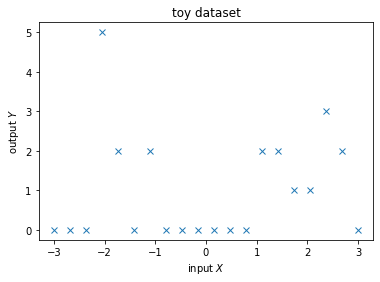

In [23]:
X = np.linspace(-3, 3, 20)
Y = np.random.poisson(2*np.sin(X)**2)

plt.figure()
plt.plot(X,Y,'x')
plt.xlabel('input $X$')
plt.ylabel('output $Y$')
plt.title('toy dataset')
plt.show()

data = (X[:,None], Y[:,None])

In [35]:
#kernel = gpflow.kernels.SquaredExponential() + gpflow.kernels.Bias()
kernel = gpflow.kernels.Matern32() + gpflow.kernels.Bias()
likelihood = gpflow.likelihoods.Poisson()
model = gpflow.models.GPMC(data, kernel, likelihood)

In [36]:
gpflow.utilities.print_summary(model)

name,class,transform,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.V,Parameter,,True,"(20, 1)",float64,[[0....


In [37]:
#k1 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=4.0)*gpflow.kernels.Periodic(period=12.0)
#k2 = gpflow.kernels.White()
#k3 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=90.0)
#kernel = k2+k3# + k2 + k
#likelihood = gpflow.likelihoods.Exponential()

#model = gpflow.models.GPMC((X_train, y_train), kernel=kernel, likelihood=likelihood)


In [38]:
model.kernel.kernels[0].lengthscale.prior = tfp.distributions.Normal(f64(1.), f64(1.))
model.kernel.kernels[0].variance.prior =  tfp.distributions.Gamma(f64(1.), f64(1.))
#model.kernel.kernels[0].period.prior = tfp.distributions.Normal(f64(np.pi), f64(1.))
model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))


In [39]:
gpflow.utilities.print_summary(model)

name,class,transform,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.V,Parameter,,True,"(20, 1)",float64,[[0....


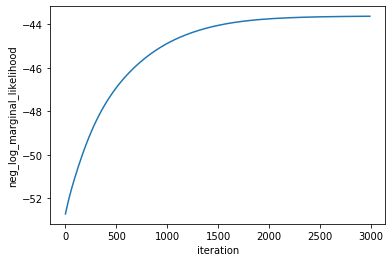

In [40]:
@tf.function(autograph=False)
def optimization_step(optimizer, model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.log_marginal_likelihood()
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return - objective

def run_adam(model, iterations):
    logf = []
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = optimization_step(adam, model)
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

maxiter = ci_niter(3000)
logf = run_adam(model, maxiter) # start near Maximum a posteriori (MAP)

plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('neg_log_marginal_likelihood');


In [41]:
num_samples = 5000

hmc_helper =  gpflow.optimizers.SamplingHelper(
    model.trainable_parameters,
    model.log_marginal_likelihood
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=10,
    step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc,
    num_adaptation_steps=10,
    target_accept_prob=f64(.75),
    adaptation_rate=0.1
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=300,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, _ = run_chain_fn()



In [42]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []

for i in range(num_samples):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)


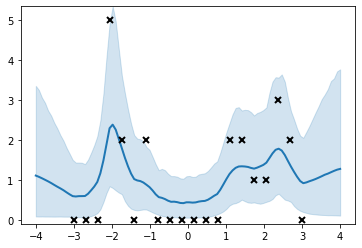

In [43]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)));


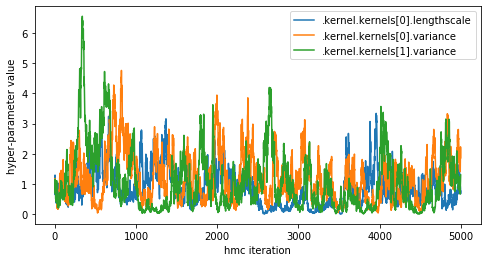

In [44]:
parameter_samples = hmc_helper.convert_constrained_values(samples)
param_to_name = {param: name for name, param in
                 gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in
                 enumerate(model.trainable_parameters)}
hyperparameters = ['.kernel.kernels[0].lengthscale',
                   '.kernel.kernels[0].variance',
                   '.kernel.kernels[1].variance']


plt.figure(figsize=(8,4))
for hp in hyperparameters:
    plt.plot(parameter_samples[name_to_index[hp]], label=hp)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value');

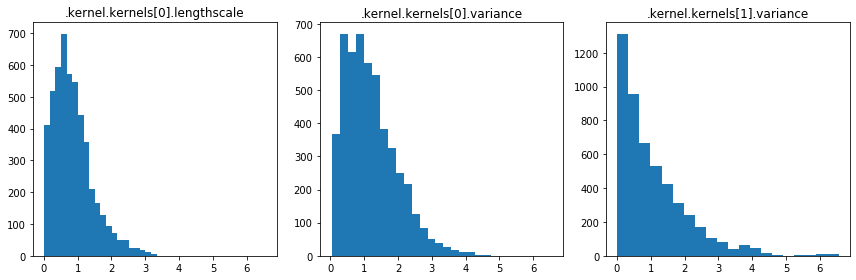

In [45]:
fig, axarr = plt.subplots(1, len(hyperparameters), sharex=True, figsize=(12,4))
for i, hyp in enumerate(hyperparameters):
    ax = axarr[i]
    ax.hist(parameter_samples[name_to_index[hyp]],bins=20)
    ax.set_title(hyp);
plt.tight_layout()

## Robust Regression

In [124]:
from random import sample
import copy

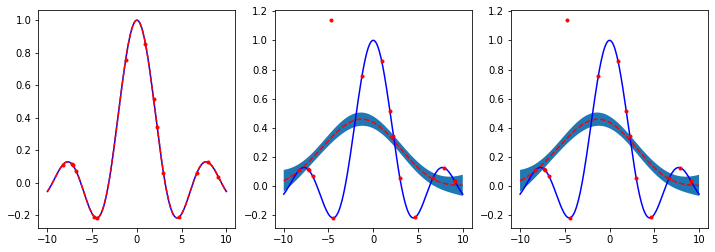

In [333]:
X = np.linspace(-10, 10, 200).reshape((-1,1))
Y = np.sin(X)/X

idx = sorted(sample(range(len(X)), 15))
#idx1 = [2, 6, 9, 10, 21, 39, 46, 50, 59, 60, 66, 68, 72, 86, 90]

X_train = X[idx]
y1_train = Y[idx]
y2_train = copy.deepcopy(y1_train)
y2_train[4] = 1.13759

data1 = (X_train, y1_train)
data2 = (X_train, y2_train)

kernel = gpflow.kernels.SquaredExponential() + gpflow.kernels.White()
model1 = gpflow.models.GPR(data1, kernel)
model2 = gpflow.models.GPR(data2, kernel)

model1.likelihood.variance.assign(0.01)
model1.kernel.kernels[0].variance.assign(0.3)
model1.kernel.kernels[0].lengthscale.assign(1)
model1.kernel.kernels[1].variance.assign(2)

model2.likelihood.variance.assign(0.01)
model2.kernel.kernels[0].variance.assign(0.1)
model2.kernel.kernels[0].lengthscale.assign(1)
model2.kernel.kernels[0].variance.assign(2)


opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - model1.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        model1.trainable_variables,
                        options=dict(maxiter=500))

def objective_closure():
    return - model2.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        model2.trainable_variables,
                        options=dict(maxiter=500))

f1_star_mean, f1_star_covar = model1.predict_f(X)
f2_star_mean, f2_star_covar = model2.predict_f(X)

error1 = 1.96 * tf.squeeze(tf.linalg.diag(f1_star_covar))
error2 = 1.96 * tf.squeeze(tf.linalg.diag(f2_star_covar))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

ax1.plot(X, Y, 'b-')
ax1.plot(X_train, y1_train, 'r.')
ax1.plot(X, f1_star_mean, 'r--')
ax1.fill_between(X.ravel(), tf.squeeze(f1_star_mean)+error1, tf.squeeze(f1_star_mean)-error1)

ax2.plot(X, Y, 'b-')
ax2.plot(X_train, y2_train, 'r.')
ax2.plot(X, f2_star_mean, 'r--')
ax2.fill_between(X.ravel(), tf.squeeze(f2_star_mean)+error2, tf.squeeze(f2_star_mean)-error2)

ax3.plot(X, Y, 'b-')
ax3.plot(X_train, y2_train, 'r.')
ax3.plot(X, f2_star_mean, 'r--')
ax3.fill_between(X.ravel(), tf.squeeze(f2_star_mean)+error2, tf.squeeze(f2_star_mean)-error2)

plt.show()

In [38]:
m.likelihood.variance.assign(0.01)
m.kernel.lengthscale.assign(1)


opt = gpflow.optimizers.Scipy()
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

In [39]:
gpflow.utilities.print_summary(model)

name,class,transform,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.0
GPMC.V,Parameter,,True,"(20, 1)",float64,[[0....


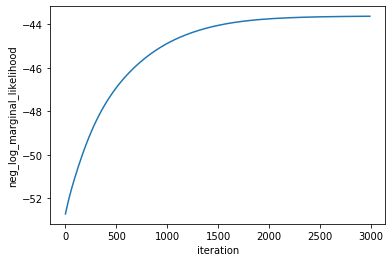

In [40]:
@tf.function(autograph=False)
def optimization_step(optimizer, model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.log_marginal_likelihood()
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return - objective

def run_adam(model, iterations):
    logf = []
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = optimization_step(adam, model)
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

maxiter = ci_niter(3000)
logf = run_adam(model, maxiter) # start near Maximum a posteriori (MAP)

plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('neg_log_marginal_likelihood');


In [41]:
num_samples = 5000

hmc_helper =  gpflow.optimizers.SamplingHelper(
    model.trainable_parameters,
    model.log_marginal_likelihood
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=10,
    step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc,
    num_adaptation_steps=10,
    target_accept_prob=f64(.75),
    adaptation_rate=0.1
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=300,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, _ = run_chain_fn()



In [42]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []

for i in range(num_samples):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)


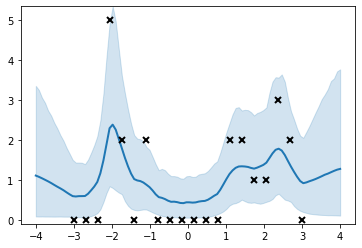

In [43]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)));


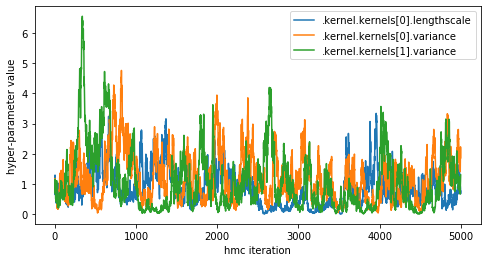

In [44]:
parameter_samples = hmc_helper.convert_constrained_values(samples)
param_to_name = {param: name for name, param in
                 gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in
                 enumerate(model.trainable_parameters)}
hyperparameters = ['.kernel.kernels[0].lengthscale',
                   '.kernel.kernels[0].variance',
                   '.kernel.kernels[1].variance']


plt.figure(figsize=(8,4))
for hp in hyperparameters:
    plt.plot(parameter_samples[name_to_index[hp]], label=hp)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value');

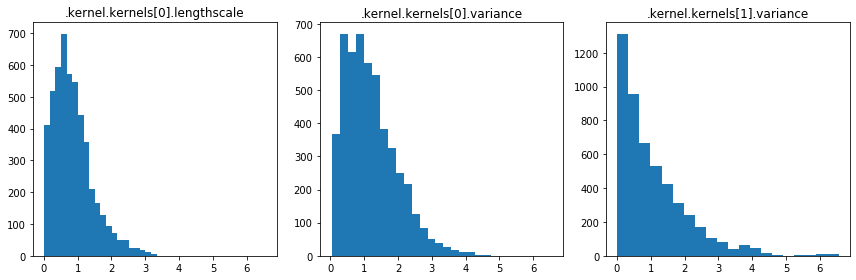

In [45]:
fig, axarr = plt.subplots(1, len(hyperparameters), sharex=True, figsize=(12,4))
for i, hyp in enumerate(hyperparameters):
    ax = axarr[i]
    ax.hist(parameter_samples[name_to_index[hyp]],bins=20)
    ax.set_title(hyp);
plt.tight_layout()